In [9]:
import numpy as np
import torch
from torch import FloatTensor,Tensor,LongTensor
from Policy import REINFORCE
import gym
import random
import matplotlib.pyplot as plt
import time

# REINFORCE
We define a function to run REINFORCE algorithm on.

In [2]:
def Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model
    
    Returns:
        scores: Score per episode in a list
    """
    
    
    scores = []
    env = gym.make("CartPole-v1")
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, learning_rate, future_reward_discount_factor, hidden_shape)

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()
        rewards = []
        log_probs = []

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            #Action selection is done by the policy
            action, log_prob = agent.model.pick(state)

            #Get example
            state, reward, done, _ = env.step(action)

            rewards.append(reward)
            log_probs.append(log_prob)

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break
        
        rewards = torch.tensor(rewards)
        log_probs = torch.cat(log_probs)
        agent.update(rewards,log_probs)

        scores.append(t+1)
    return scores

    

Trying it out

In [10]:
#Parameters
total_episodes = 1000
learning_rate = 1e-2
future_reward_discount_factor = 1
hidden_shape = [32]

score = Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape)

Episode 0: Score 25/500
Episode 1: Score 23/500
Episode 2: Score 27/500
Episode 3: Score 19/500
Episode 4: Score 20/500
Episode 5: Score 16/500
Episode 6: Score 19/500
Episode 7: Score 31/500
Episode 8: Score 37/500
Episode 9: Score 18/500
Episode 10: Score 45/500
Episode 11: Score 26/500
Episode 12: Score 40/500
Episode 13: Score 31/500
Episode 14: Score 61/500
Episode 15: Score 30/500
Episode 16: Score 39/500
Episode 17: Score 46/500
Episode 18: Score 69/500
Episode 19: Score 57/500
Episode 20: Score 32/500
Episode 21: Score 24/500
Episode 22: Score 33/500
Episode 23: Score 43/500
Episode 24: Score 37/500
Episode 25: Score 47/500
Episode 26: Score 83/500
Episode 27: Score 79/500
Episode 28: Score 84/500
Episode 29: Score 38/500
Episode 30: Score 27/500
Episode 31: Score 39/500
Episode 32: Score 46/500
Episode 33: Score 36/500
Episode 34: Score 58/500
Episode 35: Score 14/500
Episode 36: Score 35/500
Episode 37: Score 31/500
Episode 38: Score 24/500
Episode 39: Score 74/500
Episode 40

Text(0, 0.5, 'Score')

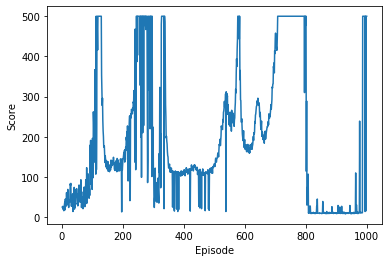

In [11]:
#Plot score per episode
plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")